In [11]:
import os
from dotenv import load_dotenv
import geopandas as gpd
from shapely.geometry import Polygon, mapping
import requests 
import json
from requests.auth import HTTPBasicAuth

In [12]:
load_dotenv()
PLANET_API_KEY = os.getenv('API_KEY')

In [14]:

"""
This script reads all shapefiles in a directory, and extracts the AOI polygons 
stored in the shapefile to a geopandas Polygon to query Planet Imagery downloads
through their API. The code logic assumes only one polygon is stored in each
shapefile.

Harrison Myers
6/7/2024

Dependencies: 
    -- os
    -- geopandas (pip install geopandas)
    -- shapely (pip install shapely)
"""

dir_path = '/Users/aidanhayes/Desktop/Planet-Imagery-API/PlanetImageryAOIs'
os.chdir(dir_path)

def getPolygons(folderPath):
    """
    Reads all shapefiles in a directory and stores their respective polygons
    in a dictionary
    Params:
        -- folderPath (str, req): Path to folder where shapefiles are stored
    returns:
        -- polygons (dict): Dictionary of polygons indexed by first two letters
                            of site name
    """
    polygons = {}
    for f in os.listdir(folderPath):
        if f.endswith('.shp'): # only read shapefiles
            fpath = os.path.join(folderPath, f) # get path to shapefile
            gdf = gpd.read_file(fpath) # read shapefile
            for geom in gdf.geometry:
                if isinstance(geom, Polygon):
                    polygons[f'{f[:3]}'] = geom
    return polygons



current_dict = getPolygons(dir_path)  

In [15]:
# BASE_URL = 'https://api.planet.com/tasking/v2/orders/'
# auth = HTTPBasicAuth(PLANET_API_KEY, '')
# res = requests.get(url=BASE_URL, auth=auth)
# print(res.status_code)

200


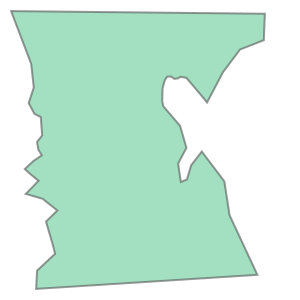

In [16]:
# Stats Seach
current_dict['Mon']

In [17]:
polygon = current_dict['Mon']
geojson_geometry = polygon.exterior.coords._coords[:, :2]

In [21]:
geojson_geometry

array([[440979.079 , 169543.6362],
       [441035.8168, 169477.3267],
       [441057.3404, 169403.0493],
       [441029.0643, 169349.8735],
       [441038.349 , 169287.413 ],
       [441059.0285, 169295.8536],
       [441073.3775, 169343.9651],
       [441109.2501, 169390.3884],
       [441185.6377, 169289.5231],
       [441203.3629, 169174.7308],
       [441297.4757, 168973.0003],
       [440548.3716, 168925.3108],
       [440551.3258, 168986.9273],
       [440612.5202, 169044.3234],
       [440603.6576, 169078.5079],
       [440581.712 , 169153.2073],
       [440620.1168, 169190.768 ],
       [440570.3172, 169230.4389],
       [440513.343 , 169246.8981],
       [440556.3902, 169291.6333],
       [440525.1599, 169316.9551],
       [440509.9668, 169331.3042],
       [440539.5089, 169358.7361],
       [440567.3629, 169377.7275],
       [440555.5461, 169397.563 ],
       [440551.3258, 169422.8848],
       [440568.629 , 169444.8304],
       [440563.9867, 169507.2909],
       [440542.4631,

In [23]:
SEARCH_ENDPOINT = 'https://api.planet.com/data/v1/quick-search'

search_params = {
   "item_types":[
      "PSScene"
   ],
   "filter":{
      "type":"AndFilter",
      "config":[
         {
            "type":"GeometryFilter",
            "field_name":"geometry",
            "config": geojson_geometry
                       
              
         },
         {
            "type":"DateRangeFilter",
            "field_name":"acquired",
            "config":{
               "gte":"2021-11-18T00:00:00Z",
            }
         },
         {
            "type":"StringInFilter",
            "field_name":"quality_category",
            "config":[
               "standard"
            ]
         },
         {
            "type":"AssetFilter",
            "config":[
               "ortho_analytic_8b"
            ]
         },
         {
            "type":"RangeFilter",
            "field_name":"cloud_cover",
            "config":{
               "gte":0,
               "lte":0.75
            },
         },
         {
            "type":"PermissionFilter",
            "config":[
               "assets:download"
            ]
         }
      ]
   }
}
headers = {
    'Authorization': f'api-key {PLANET_API_KEY}',
    'Content-Type': 'application/json'
}
response = requests.post(SEARCH_ENDPOINT, headers=headers, data=(search_params))


In [26]:
response.text

'{"message": "The data the server received was invalid JSON", "errors": []}'

In [24]:
data_dict = json.loads(response.text)

In [25]:
data_dict

{'message': 'The data the server received was invalid JSON', 'errors': []}